=== Step 1: Get reach IDs from FTS ===
Searching by basin ...https://fts.podaac.earthdata.nasa.gov/v1/rivers/reach/732520
page_size:  100 , page_number:  1 , hits:  190 , # reach_ids:  100
Total number of reaches:  100
Total number of non-duplicate reaches:  100

=== Step 2: Query Hydrocron for reach 73252000171 ===
Querying reach_id: 73252000171
URL: https://soto.podaac.earthdatacloud.nasa.gov/hydrocron/v1/timeseries
Parameters: {'feature': 'Reach', 'feature_id': '73252000171', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2024-04-16T00:00:00Z', 'fields': 'reach_id,time_str,wse'}
Response status code: 200
Response keys: dict_keys(['status', 'time', 'hits', 'results'])
Successfully retrieved 19 records

=== Step 3: Process data ===
Removed 0 fill value records

=== Results ===
      reach_id                  time_str      wse wse_units
0  73252000171 2023-09-05 04:49:59+00:00  24.1829         m
1  73252000171 2023-09-05 15:39:16+00:00  24.1167         m
2  7325200

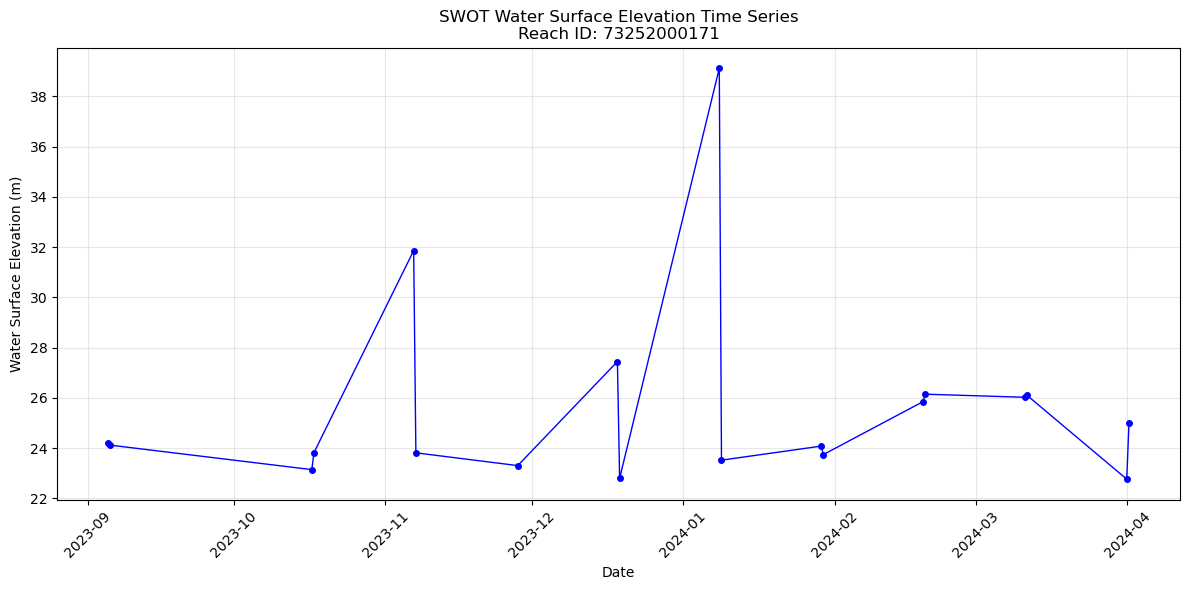


Data saved to: swot_reach_73252000171_2023-07-28_2024-04-16.csv


In [7]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from io import StringIO

# API URLs (from official notebook)
FTS_URL = "https://fts.podaac.earthdata.nasa.gov/v1"  
HYDROCRON_URL = "https://soto.podaac.earthdatacloud.nasa.gov/hydrocron/v1/timeseries"

def query_fts(query_url, params):
    """Query Feature Translation Service (FTS) for reach identifiers using the query_url parameter.
    (Copied from official notebook)

    Parameters
    ----------
    query_url: str - URL to use to query FTS
    params: dict - Dictionary of parameters to pass to query

    Returns
    -------
    dict of results: hits, page_size, page_number, reach_ids
    """
    reaches = requests.get(query_url, params=params)
    reaches_json = reaches.json()

    hits = reaches_json['hits']
    if 'search on' in reaches_json.keys():
        page_size = reaches_json['search on']['page_size']
        page_number = reaches_json['search on']['page_number']
    else:
        page_size = 0
        page_number = 0

    return {
        "hits": hits,
        "page_size": page_size,
        "page_number": page_number,
        "reach_ids": [ item['reach_id'] for item in reaches_json['results'] ]
    }

def get_reach_ids_for_basin(basin_identifier, max_reaches=None):
    """Get reach IDs for a specific basin (copied from official notebook logic)"""
    
    query_url = f"{FTS_URL}/rivers/reach/{basin_identifier}"
    print(f"Searching by basin ...{query_url}")

    page_size = 100    # Set FTS to retrieve 100 results at a time
    page_number = 1    # Set FTS to retrieve the first page of results
    hits = 1           # Set hits to initial value to start while loop
    reach_ids = []
    
    while (page_size * page_number) != 0 and len(reach_ids) < hits:
        params = { "page_size": page_size, "page_number": page_number }
        results = query_fts(query_url, params)
        
        hits = results['hits']
        page_size = results['page_size']
        page_number = results['page_number'] + 1
        reach_ids.extend(results['reach_ids'])

        print("page_size: ", page_size, ", page_number: ", page_number - 1, ", hits: ", hits, ", # reach_ids: ", len(reach_ids))
        
        if max_reaches and len(reach_ids) >= max_reaches:
            break
            
    print("Total number of reaches: ", len(reach_ids))
    reach_ids = list(set(reach_ids))    # Remove duplicates
    print("Total number of non-duplicate reaches: ", len(reach_ids))
    
    return reach_ids

def query_hydrocron_single_reach(reach_id, start_time, end_time, fields="reach_id,time_str,wse"):
    """Query Hydrocron for reach-level time series data for a single reach.
    (Adapted from official notebook)

    Parameters
    ----------
    reach_id: str - String SWORD reach identifier
    start_time: str - String time to start query
    end_time: str - String time to end query
    fields: str - Comma-separated list of fields to return in query response

    Returns
    -------
    pandas.DataFrame that contains query results
    """
    
    # Create an empty dataframe for cases where no data is returned for a reach identifier
    empty_df = pd.DataFrame({
        "reach_id": np.int64(reach_id),
        "time_str": datetime.datetime(1900, 1, 1).strftime("%Y-%m-%dT%H:%M:%S"),
        "wse": -999999999999.0,
        "wse_units": "m"
    }, index=[0])

    params = {
        "feature": "Reach",
        "feature_id": reach_id,
        "output": "csv",
        "start_time": start_time,
        "end_time": end_time,
        "fields": fields
    }
    
    print(f"Querying reach_id: {reach_id}")
    print(f"URL: {HYDROCRON_URL}")
    print(f"Parameters: {params}")
    
    try:
        results = requests.get(HYDROCRON_URL, params=params)
        print(f"Response status code: {results.status_code}")
        
        if results.status_code == 200:
            response_json = results.json()
            print(f"Response keys: {response_json.keys()}")
            
            if "results" in response_json.keys():
                results_csv = response_json["results"]["csv"]
                if results_csv.strip():  # Check if not empty
                    df = pd.read_csv(StringIO(results_csv))
                    print(f"Successfully retrieved {len(df)} records")
                else:
                    print("Empty CSV response, using empty dataframe")
                    df = empty_df
            else:
                print("No 'results' key in response, using empty dataframe")
                df = empty_df
        else:
            print(f"HTTP error {results.status_code}: {results.text}")
            df = empty_df
            
    except Exception as e:
        print(f"Error querying Hydrocron: {e}")
        df = empty_df

    return df

def clean_and_process_data(df):
    """Clean and process the data (from official notebook)"""
    if df.empty:
        return df
        
    # Remove fill values for missing observations
    original_length = len(df)
    df = df.loc[(df["wse"] != -999999999999.0)]
    print(f"Removed {original_length - len(df)} fill value records")
    
    # Convert time_str to datetime format
    if 'time_str' in df.columns:
        df['time_str'] = pd.to_datetime(df['time_str'])
    
    return df

def plot_timeseries(df, reach_id):
    """Plot the time series data for water surface elevation."""
    if df.empty:
        print("No data to plot")
        return
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['time_str'], df['wse'], 'b-o', markersize=4, linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Water Surface Elevation (m)')
    plt.title(f'SWOT Water Surface Elevation Time Series\nReach ID: {reach_id}')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage following the official notebook pattern
if __name__ == "__main__":
    # BASIN or RIVER to query FTS for (from official notebook)
    BASIN_IDENTIFIER = "732520"  # Savannah River and its tributaries in Georgia, USA
    
    print("=== Step 1: Get reach IDs from FTS ===")
    reach_ids = get_reach_ids_for_basin(BASIN_IDENTIFIER, max_reaches=10)
    
    if not reach_ids:
        print("No reach IDs found")
        exit()
    
    # Take the first reach ID for single reach analysis
    reach_id = reach_ids[0]
    print(f"\n=== Step 2: Query Hydrocron for reach {reach_id} ===")
    
    # Time parameters (from official notebook)
    start_time = "2023-07-28T00:00:00Z"
    end_time = "2024-04-16T00:00:00Z"
    fields = "reach_id,time_str,wse"
    
    # Query Hydrocron
    df = query_hydrocron_single_reach(reach_id, start_time, end_time, fields)
    
    print(f"\n=== Step 3: Process data ===")
    df = clean_and_process_data(df)
    
    if not df.empty:
        print("\n=== Results ===")
        print(df.head())
        print(f"\nData shape: {df.shape}")
        if 'time_str' in df.columns:
            print(f"Date range: {df['time_str'].min()} to {df['time_str'].max()}")
        
        # Plot the time series
        plot_timeseries(df, reach_id)
        
        # Save to CSV
        output_filename = f"swot_reach_{reach_id}_{start_time[:10]}_{end_time[:10]}.csv"
        df.to_csv(output_filename, index=False)
        print(f"\nData saved to: {output_filename}")
    else:
        print("\n=== No Data Available ===")
        print("This reach may not have SWOT observations in the specified time range.")
        print("Try a different reach ID or date range.")
        
        # Show some alternative reach IDs to try
        if len(reach_ids) > 1:
            print(f"\nOther reach IDs in this basin to try:")
            for i, rid in enumerate(reach_ids[1:6]):  # Show next 5
                print(f"  {rid}")

=== Missouri River Reach Analysis ===
Reach ID: 74300100025
River: Missouri River
Location: 29.02°N, -89.34°W
Upstream reach: 74210000015
Downstream reach: 74300100016

=== Querying Hydrocron for reach 74300100025 ===
Querying reach_id: 74300100025
URL: https://soto.podaac.earthdatacloud.nasa.gov/hydrocron/v1/timeseries
Parameters: {'feature': 'Reach', 'feature_id': '74300100025', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2024-04-16T00:00:00Z', 'fields': 'reach_id,time_str,wse,width,area_total'}
Response status code: 200
Response keys: dict_keys(['status', 'time', 'hits', 'results'])
Successfully retrieved 34 records

=== Processing data ===
Removed 1 fill value records

=== Results ===
      reach_id                  time_str     wse       width  area_total  \
0  74300100025 2023-07-28 11:20:04+00:00  0.1441  588.974922   6524747.4   
1  74300100025 2023-08-07 09:42:23+00:00  0.1324  575.287186   6373112.7   
2  74300100025 2023-08-29 17:19:50+00:00  0.2943  

C:\Users\jspier\AppData\Local\Temp\ipykernel_15276\1952765390.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_str'] = pd.to_datetime(df['time_str'])


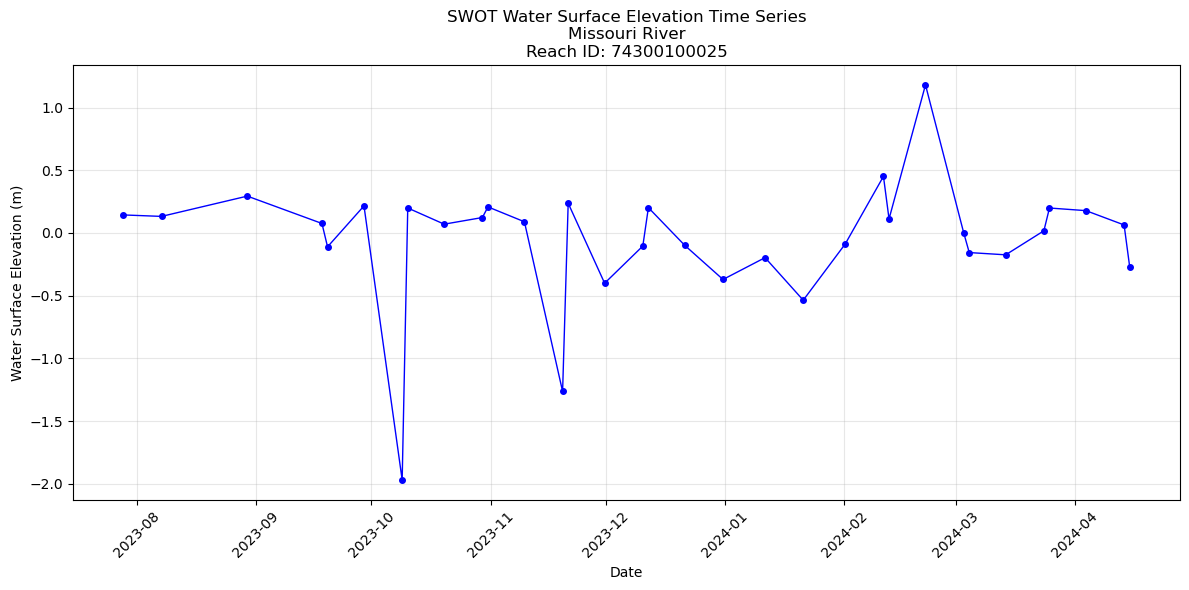


Data saved to: swot_missouri_river_74300100025_2023-07-28_2024-04-16.csv
Summary saved to: swot_missouri_river_74300100025_summary.csv


In [8]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from io import StringIO

# API URLs (from official notebook)
HYDROCRON_URL = "https://soto.podaac.earthdatacloud.nasa.gov/hydrocron/v1/timeseries"

def query_hydrocron_single_reach(reach_id, start_time, end_time, fields="reach_id,time_str,wse"):
    """Query Hydrocron for reach-level time series data for a single reach.
    (Adapted from official notebook)

    Parameters
    ----------
    reach_id: str - String SWORD reach identifier
    start_time: str - String time to start query
    end_time: str - String time to end query
    fields: str - Comma-separated list of fields to return in query response

    Returns
    -------
    pandas.DataFrame that contains query results
    """
    
    # Create an empty dataframe for cases where no data is returned
    empty_df = pd.DataFrame({
        "reach_id": [reach_id],
        "time_str": [datetime.datetime(1900, 1, 1).strftime("%Y-%m-%dT%H:%M:%S")],
        "wse": [-999999999999.0],
        "wse_units": ["m"]
    })

    params = {
        "feature": "Reach",
        "feature_id": reach_id,
        "output": "csv",
        "start_time": start_time,
        "end_time": end_time,
        "fields": fields
    }
    
    print(f"Querying reach_id: {reach_id}")
    print(f"URL: {HYDROCRON_URL}")
    print(f"Parameters: {params}")
    
    try:
        results = requests.get(HYDROCRON_URL, params=params)
        print(f"Response status code: {results.status_code}")
        
        if results.status_code == 200:
            response_json = results.json()
            print(f"Response keys: {response_json.keys()}")
            
            if "results" in response_json.keys():
                results_csv = response_json["results"]["csv"]
                if results_csv.strip():  # Check if not empty
                    df = pd.read_csv(StringIO(results_csv))
                    print(f"Successfully retrieved {len(df)} records")
                else:
                    print("Empty CSV response, using empty dataframe")
                    df = empty_df
            else:
                print("No 'results' key in response, using empty dataframe")
                df = empty_df
        else:
            print(f"HTTP error {results.status_code}")
            try:
                error_response = results.json()
                print(f"Error details: {error_response}")
            except:
                print(f"Error text: {results.text}")
            df = empty_df
            
    except Exception as e:
        print(f"Error querying Hydrocron: {e}")
        df = empty_df

    return df

def clean_and_process_data(df):
    """Clean and process the data (from official notebook)"""
    if df.empty:
        return df
        
    # Remove fill values for missing observations
    original_length = len(df)
    df = df.loc[(df["wse"] != -999999999999.0)]
    removed_count = original_length - len(df)
    if removed_count > 0:
        print(f"Removed {removed_count} fill value records")
    
    # Convert time_str to datetime format
    if 'time_str' in df.columns and len(df) > 0:
        df['time_str'] = pd.to_datetime(df['time_str'])
    
    return df

def plot_timeseries(df, reach_id, river_name=""):
    """Plot the time series data for water surface elevation."""
    if df.empty:
        print("No data to plot")
        return
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['time_str'], df['wse'], 'b-o', markersize=4, linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Water Surface Elevation (m)')
    title = f'SWOT Water Surface Elevation Time Series\n{river_name}\nReach ID: {reach_id}'
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Missouri River reach analysis
if __name__ == "__main__":
    # Specific reach information
    reach_id = "74300100025"
    river_name = "Missouri River"
    lat = 29.02
    lon = -89.34
    rch_id_up = "74210000015"  # Upstream reach
    rch_id_dn = "74300100016"  # Downstream reach
    
    print("=== Missouri River Reach Analysis ===")
    print(f"Reach ID: {reach_id}")
    print(f"River: {river_name}")
    print(f"Location: {lat}°N, {lon}°W")
    print(f"Upstream reach: {rch_id_up}")
    print(f"Downstream reach: {rch_id_dn}")
    
    print(f"\n=== Querying Hydrocron for reach {reach_id} ===")
    
    # Time parameters - using the date range from the official notebook
    start_time = "2023-07-28T00:00:00Z"
    end_time = "2024-04-16T00:00:00Z"
    
    # You can customize fields as needed:
    # Basic fields: "reach_id,time_str,wse"
    # Extended fields: "reach_id,time_str,wse,width,area_total,area_detct"
    fields = "reach_id,time_str,wse,width,area_total"
    
    # Query Hydrocron
    df = query_hydrocron_single_reach(reach_id, start_time, end_time, fields)
    
    print(f"\n=== Processing data ===")
    df = clean_and_process_data(df)
    
    if not df.empty:
        print("\n=== Results ===")
        print(df.head(10))  # Show first 10 records
        print(f"\nData shape: {df.shape}")
        if 'time_str' in df.columns:
            print(f"Date range: {df['time_str'].min()} to {df['time_str'].max()}")
        
        # Show some basic statistics
        if 'wse' in df.columns:
            print(f"Water Surface Elevation stats:")
            print(f"  Mean: {df['wse'].mean():.2f} m")
            print(f"  Min: {df['wse'].min():.2f} m")
            print(f"  Max: {df['wse'].max():.2f} m")
            print(f"  Std: {df['wse'].std():.2f} m")
        
        if 'width' in df.columns:
            print(f"River Width stats:")
            print(f"  Mean: {df['width'].mean():.2f} m")
            print(f"  Min: {df['width'].min():.2f} m")
            print(f"  Max: {df['width'].max():.2f} m")
        
        # Plot the time series
        plot_timeseries(df, reach_id, river_name)
        
        # Save to CSV
        output_filename = f"swot_missouri_river_{reach_id}_{start_time[:10]}_{end_time[:10]}.csv"
        df.to_csv(output_filename, index=False)
        print(f"\nData saved to: {output_filename}")
        
        # Also create a summary
        summary = {
            "reach_id": reach_id,
            "river_name": river_name,
            "latitude": lat,
            "longitude": lon,
            "upstream_reach": rch_id_up,
            "downstream_reach": rch_id_dn,
            "num_observations": len(df),
            "date_range_start": df['time_str'].min() if 'time_str' in df.columns else None,
            "date_range_end": df['time_str'].max() if 'time_str' in df.columns else None,
            "mean_wse_m": df['wse'].mean() if 'wse' in df.columns else None,
            "mean_width_m": df['width'].mean() if 'width' in df.columns else None
        }
        
        summary_df = pd.DataFrame([summary])
        summary_filename = f"swot_missouri_river_{reach_id}_summary.csv"
        summary_df.to_csv(summary_filename, index=False)
        print(f"Summary saved to: {summary_filename}")
        
    else:
        print("\n=== No Data Available ===")
        print("This reach may not have SWOT observations in the specified time range.")
        print("\nTrying alternative approaches...")
        
        # Try different date ranges
        print("\n--- Trying more recent date range ---")
        df2 = query_hydrocron_single_reach(reach_id, "2024-01-01T00:00:00Z", "2024-12-31T00:00:00Z", fields)
        df2 = clean_and_process_data(df2)
        
        if not df2.empty:
            print(f"Found {len(df2)} records with recent dates!")
            plot_timeseries(df2, reach_id, river_name)
        else:
            print("No data found in recent dates either.")
            print("\nThis could mean:")
            print("1. SWOT hasn't passed over this reach during the specified time periods")
            print("2. The reach may not meet SWOT's minimum width requirements (~100m)")
            print("3. There may have been data quality issues during the passes")

SWOT Multi-Reach Analysis
Analyzing 4 reach IDs
Time range: 2023-07-28T00:00:00Z to 2025-05-03T00:00:00Z

Processing Reach ID: 75376000081
Querying reach_id: 75376000081
Parameters: {'feature': 'Reach', 'feature_id': '75376000081', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2025-05-03T00:00:00Z', 'fields': 'reach_id,time_str,wse,width,area_total'}
Response status code: 200
Successfully retrieved 52 records
Original data: 52 records
Removed 26 fill value records
Final data after quality filtering: 26 records

=== Results for Reach 75376000081 ===
Number of observations: 26
Date range: 2023-08-04 09:36:46+00:00 to 2025-04-21 08:09:09+00:00
Water Surface Elevation:
  Mean: 1.10 m
  Min: -0.46 m
  Max: 3.30 m
  Std: 0.81 m
River Width:
  Mean: 135.93 m
  Min: 108.35 m
  Max: 170.13 m
Total Area:
  Mean: 2428900 m²
  Min: 1936047 m²
  Max: 3039919 m²


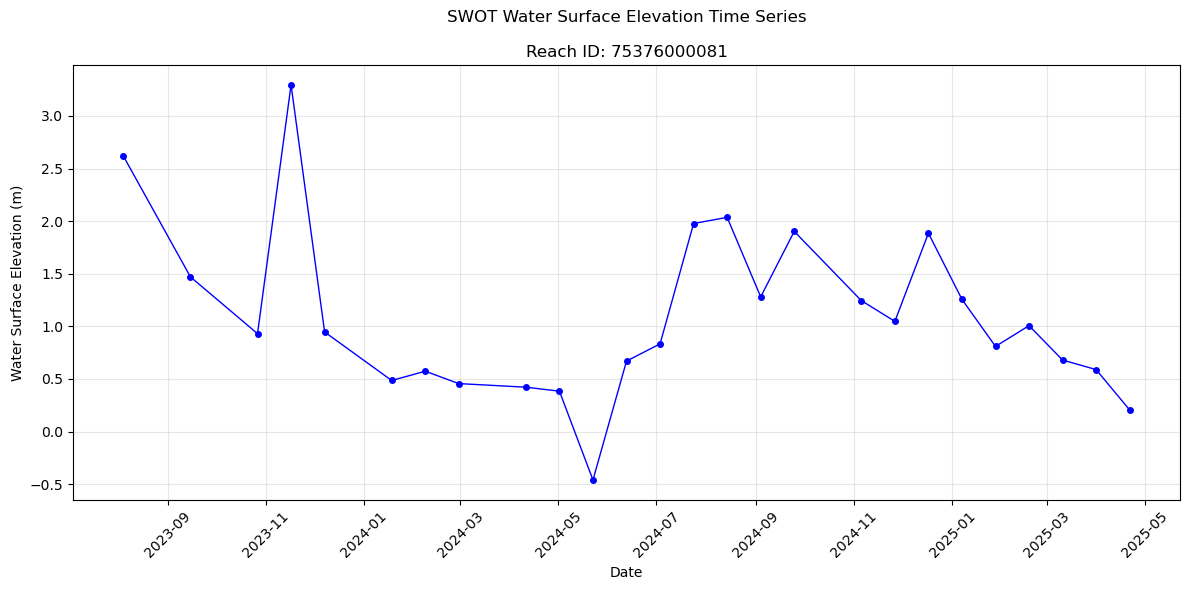

Data saved to: swot_reach_75376000081_2023-07-28_2025-05-03.csv

Processing Reach ID: 75380100011
Querying reach_id: 75380100011
Parameters: {'feature': 'Reach', 'feature_id': '75380100011', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2025-05-03T00:00:00Z', 'fields': 'reach_id,time_str,wse,width,area_total'}
Response status code: 200
Successfully retrieved 48 records
Original data: 48 records
Final data after quality filtering: 48 records

=== Results for Reach 75380100011 ===
Number of observations: 48
Date range: 2023-09-18 14:09:54+00:00 to 2025-05-01 06:30:05+00:00
Water Surface Elevation:
  Mean: 2.68 m
  Min: -3.75 m
  Max: 4.55 m
  Std: 1.29 m
River Width:
  Mean: 241.95 m
  Min: 145.51 m
  Max: 340.72 m
Total Area:
  Mean: 4740706 m²
  Min: 2719704 m²
  Max: 6671900 m²


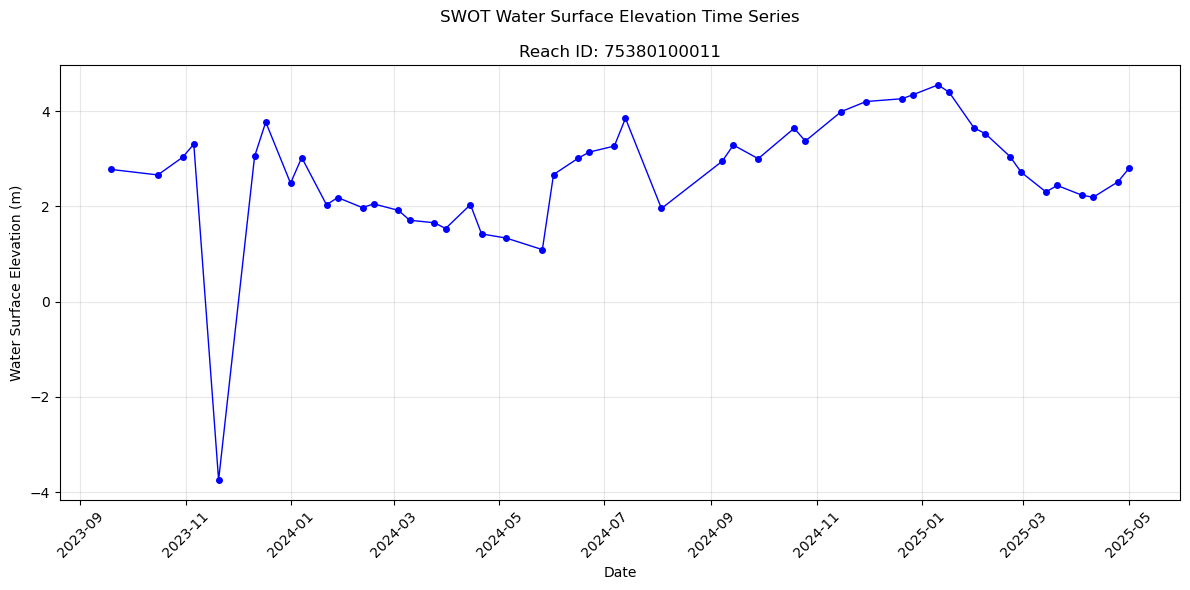

Data saved to: swot_reach_75380100011_2023-07-28_2025-05-03.csv

Processing Reach ID: 61100201775
Querying reach_id: 61100201775
Parameters: {'feature': 'Reach', 'feature_id': '61100201775', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2025-05-03T00:00:00Z', 'fields': 'reach_id,time_str,wse,width,area_total'}
Response status code: 200
Successfully retrieved 84 records
Original data: 84 records
Removed 30 fill value records
Final data after quality filtering: 54 records

=== Results for Reach 61100201775 ===
Number of observations: 54
Date range: 2023-08-01 09:33:12+00:00 to 2025-05-02 17:34:00+00:00
Water Surface Elevation:
  Mean: 1.12 m
  Min: -0.98 m
  Max: 3.52 m
  Std: 0.56 m
River Width:
  Mean: 361.72 m
  Min: 260.77 m
  Max: 954.49 m
Total Area:
  Mean: 3895588 m²
  Min: 1984621 m²
  Max: 10055177 m²


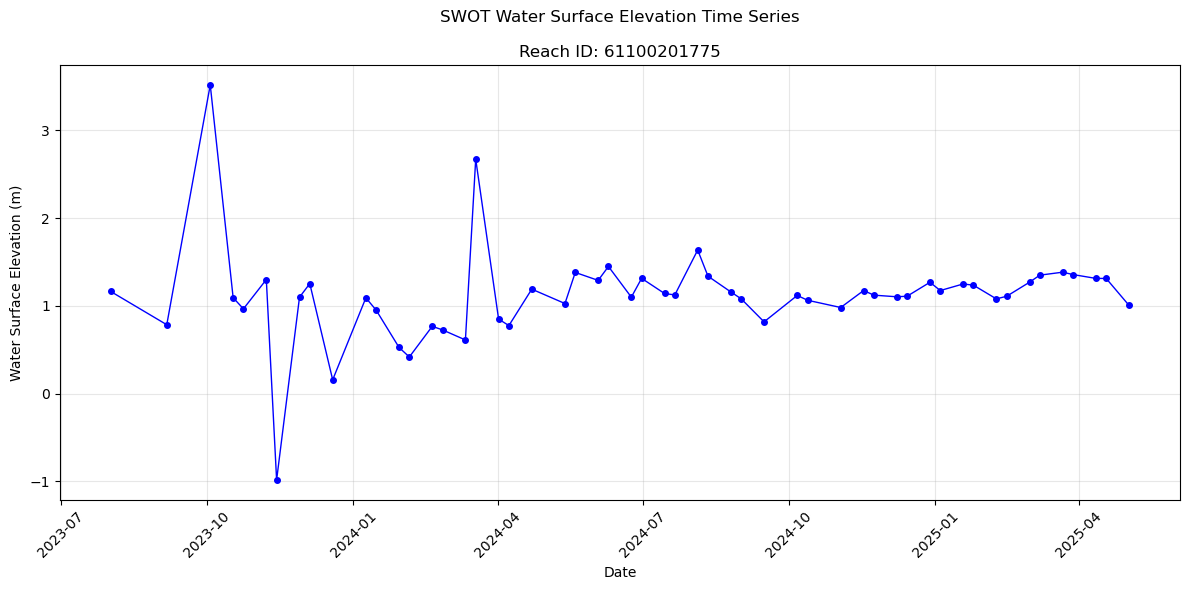

Data saved to: swot_reach_61100201775_2023-07-28_2025-05-03.csv

Processing Reach ID: 61201000225
Querying reach_id: 61201000225
Parameters: {'feature': 'Reach', 'feature_id': '61201000225', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2025-05-03T00:00:00Z', 'fields': 'reach_id,time_str,wse,width,area_total'}
Response status code: 200
Successfully retrieved 46 records
Original data: 46 records
Removed 1 fill value records
Final data after quality filtering: 45 records

=== Results for Reach 61201000225 ===
Number of observations: 45
Date range: 2023-07-31 09:33:31+00:00 to 2025-05-01 17:32:36+00:00
Water Surface Elevation:
  Mean: 1.09 m
  Min: -2.76 m
  Max: 7.81 m
  Std: 1.64 m
River Width:
  Mean: 977.15 m
  Min: 83.54 m
  Max: 1924.81 m
Total Area:
  Mean: 7131960 m²
  Min: 289309 m²
  Max: 18939832 m²


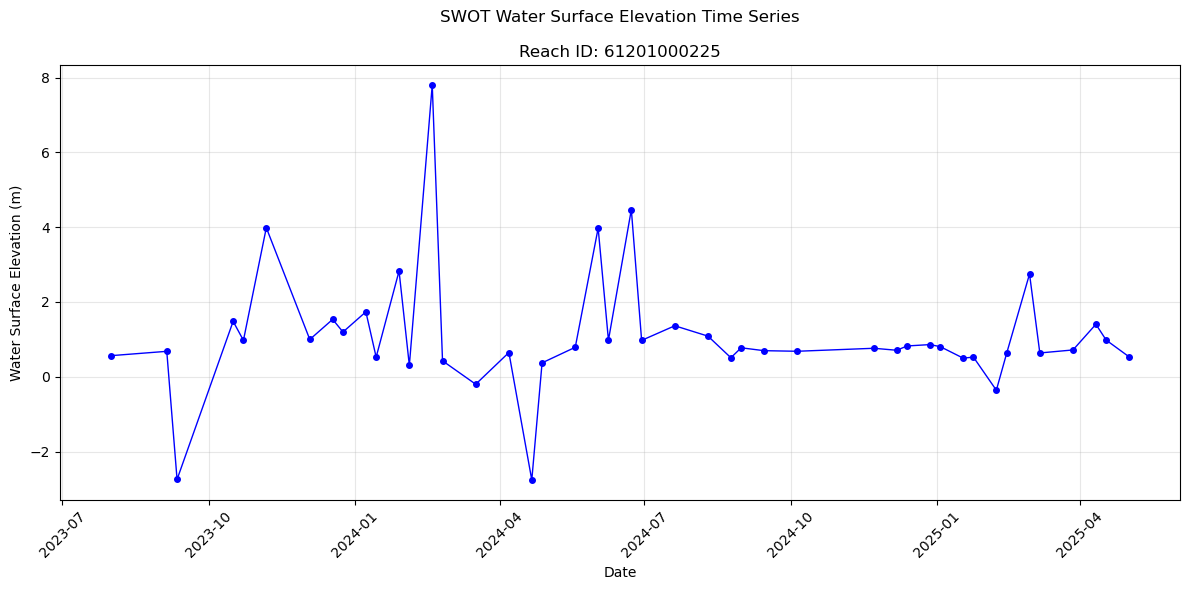

Data saved to: swot_reach_61201000225_2023-07-28_2025-05-03.csv

COMBINED SUMMARY

Reach Summary:
   reach_id river_name  num_observations  success
75376000081                           26     True
75380100011                           48     True
61100201775                           54     True
61201000225                           45     True

Reaches with data (4 of 4):
  75376000081: 26 observations
    WSE: 1.10 ± 0.81 m
    Width: 136 m
  75380100011: 48 observations
    WSE: 2.68 ± 1.29 m
    Width: 242 m
  61100201775: 54 observations
    WSE: 1.12 ± 0.56 m
    Width: 362 m
  61201000225: 45 observations
    WSE: 1.09 ± 1.64 m
    Width: 977 m

Combined summary saved to: swot_multi_reach_summary_2023-07-28_2025-05-03.csv

Analysis Complete!


In [20]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from io import StringIO

# API URLs
FTS_URL = "https://fts.podaac.earthdata.nasa.gov/v1"  
HYDROCRON_URL = "https://soto.podaac.earthdatacloud.nasa.gov/hydrocron/v1/timeseries"

def query_hydrocron_single_reach(reach_id, start_time, end_time, fields="reach_id,time_str,wse"):
    """Query Hydrocron for reach-level time series data for a single reach."""
    
    # Create an empty dataframe for cases where no data is returned
    empty_df = pd.DataFrame({
        "reach_id": [reach_id],
        "time_str": [datetime.datetime(1900, 1, 1).strftime("%Y-%m-%dT%H:%M:%S")],
        "wse": [-999999999999.0],
        "wse_units": ["m"]
    })

    params = {
        "feature": "Reach",
        "feature_id": reach_id,
        "output": "csv",
        "start_time": start_time,
        "end_time": end_time,
        "fields": fields
    }
    
    print(f"Querying reach_id: {reach_id}")
    print(f"Parameters: {params}")
    
    try:
        results = requests.get(HYDROCRON_URL, params=params)
        print(f"Response status code: {results.status_code}")
        
        if results.status_code == 200:
            response_json = results.json()
            
            if "results" in response_json.keys():
                results_csv = response_json["results"]["csv"]
                if results_csv.strip():  # Check if not empty
                    df = pd.read_csv(StringIO(results_csv))
                    print(f"Successfully retrieved {len(df)} records")
                else:
                    print("Empty CSV response")
                    df = empty_df
            else:
                print("No 'results' key in response")
                df = empty_df
        else:
            print(f"HTTP error {results.status_code}")
            try:
                error_response = results.json()
                print(f"Error details: {error_response}")
            except:
                print(f"Error text: {results.text}")
            df = empty_df
            
    except Exception as e:
        print(f"Error querying Hydrocron: {e}")
        df = empty_df

    return df

def clean_and_process_data(df):
    """Clean and process the data - fixed pandas warning"""
    if df.empty:
        return df
        
    print(f"Original data: {len(df)} records")
    
    # Remove fill values for missing observations
    original_length = len(df)
    df = df.loc[(df["wse"] != -999999999999.0)].copy()  # Added .copy() to fix warning
    removed_count = original_length - len(df)
    if removed_count > 0:
        print(f"Removed {removed_count} fill value records")
    
    # Quality filtering based on available fields
    if 'wse_qual' in df.columns:
        original_length = len(df)
        df = df.loc[df['wse_qual'] == 0].copy()
        removed_count = original_length - len(df)
        print(f"Quality filtering: removed {removed_count} poor quality records (wse_qual != 0)")
    
    if 'obs_frac_n' in df.columns:
        original_length = len(df)
        df = df.loc[df['obs_frac_n'] > 0.8].copy()
        removed_count = original_length - len(df)
        print(f"Node coverage filtering: removed {removed_count} records with obs_frac_n <= 0.8")
    
    if 'n_good_nod' in df.columns:
        original_length = len(df)
        df = df.loc[df['n_good_nod'] >= 5].copy()
        removed_count = original_length - len(df)
        print(f"Good nodes filtering: removed {removed_count} records with n_good_nod < 5")
    
    # Convert time_str to datetime format - fixed warning
    if 'time_str' in df.columns and len(df) > 0:
        df = df.copy()  # Ensure we have a copy
        df['time_str'] = pd.to_datetime(df['time_str'])
    
    print(f"Final data after quality filtering: {len(df)} records")
    return df

def plot_timeseries(df, reach_id, river_name=""):
    """Plot the time series data for water surface elevation."""
    if df.empty:
        print("No data to plot")
        return
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['time_str'], df['wse'], 'b-o', markersize=4, linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Water Surface Elevation (m)')
    title = f'SWOT Water Surface Elevation Time Series\n{river_name}\nReach ID: {reach_id}'
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def get_river_name_from_reach_id(reach_id):
    """Try to get river name from FTS (optional - may not always work)"""
    try:
        # Try to query FTS for river name
        query_url = f"{FTS_URL}/rivers/reach/{reach_id}"
        response = requests.get(query_url, params={"page_size": 1, "page_number": 1})
        if response.status_code == 200:
            data = response.json()
            if 'results' in data and len(data['results']) > 0:
                # FTS doesn't always return river names, so this is optional
                return ""
        return ""
    except:
        return ""

def process_single_reach(reach_id, start_time, end_time, fields=None):
    """Process a single reach and return summary info"""
    
    if fields is None:
        fields = "reach_id,time_str,wse,width,area_total"
    
    print(f"\n{'='*60}")
    print(f"Processing Reach ID: {reach_id}")
    print(f"{'='*60}")
    
    # Get river name (if possible)
    river_name = get_river_name_from_reach_id(reach_id)
    
    # Query Hydrocron
    df = query_hydrocron_single_reach(reach_id, start_time, end_time, fields)
    
    # Process data
    df = clean_and_process_data(df)
    
    summary = {
        "reach_id": reach_id,
        "river_name": river_name,
        "num_observations": len(df),
        "success": not df.empty
    }
    
    if not df.empty:
        print(f"\n=== Results for Reach {reach_id} ===")
        print(f"Number of observations: {len(df)}")
        print(f"Date range: {df['time_str'].min()} to {df['time_str'].max()}")
        
        # Basic statistics
        if 'wse' in df.columns:
            print(f"Water Surface Elevation:")
            print(f"  Mean: {df['wse'].mean():.2f} m")
            print(f"  Min: {df['wse'].min():.2f} m")
            print(f"  Max: {df['wse'].max():.2f} m")
            print(f"  Std: {df['wse'].std():.2f} m")
            
            summary.update({
                "date_range_start": df['time_str'].min(),
                "date_range_end": df['time_str'].max(),
                "mean_wse_m": df['wse'].mean(),
                "min_wse_m": df['wse'].min(),
                "max_wse_m": df['wse'].max(),
                "std_wse_m": df['wse'].std()
            })
        
        if 'width' in df.columns:
            print(f"River Width:")
            print(f"  Mean: {df['width'].mean():.2f} m")
            print(f"  Min: {df['width'].min():.2f} m")
            print(f"  Max: {df['width'].max():.2f} m")
            
            summary.update({
                "mean_width_m": df['width'].mean(),
                "min_width_m": df['width'].min(),
                "max_width_m": df['width'].max()
            })
        
        if 'area_total' in df.columns:
            print(f"Total Area:")
            print(f"  Mean: {df['area_total'].mean():.0f} m²")
            print(f"  Min: {df['area_total'].min():.0f} m²")
            print(f"  Max: {df['area_total'].max():.0f} m²")
            
            summary.update({
                "mean_area_m2": df['area_total'].mean(),
                "min_area_m2": df['area_total'].min(),
                "max_area_m2": df['area_total'].max()
            })
        
        # Plot the time series
        plot_timeseries(df, reach_id, river_name)
        
        # Save individual files
        output_filename = f"swot_reach_{reach_id}_{start_time[:10]}_{end_time[:10]}.csv"
        df.to_csv(output_filename, index=False)
        print(f"Data saved to: {output_filename}")
        
    else:
        print(f"\n=== No Data Available for Reach {reach_id} ===")
        print("This reach may not have SWOT observations in the specified time range.")
        
        summary.update({
            "date_range_start": None,
            "date_range_end": None,
            "mean_wse_m": None,
            "min_wse_m": None,
            "max_wse_m": None,
            "std_wse_m": None,
            "mean_width_m": None,
            "min_width_m": None,
            "max_width_m": None,
            "mean_area_m2": None,
            "min_area_m2": None,
            "max_area_m2": None
        })
    
    return summary

# Multiple reach analysis
if __name__ == "__main__":
    # List of reach IDs to process
    reach_ids = [
        "75376000081",  # Unknown river
        "75380100011",  # Unknown river  
        "61100201775",  # Unknown river
        "61201000225"   # Unknown river
    ]
    
    # Time parameters
    start_time = "2023-07-28T00:00:00Z"
    end_time = "2025-05-03T00:00:00Z"
    
    # Fields to download
    fields = "reach_id,time_str,wse,width,area_total"
    
    print("SWOT Multi-Reach Analysis")
    print("=" * 60)
    print(f"Analyzing {len(reach_ids)} reach IDs")
    print(f"Time range: {start_time} to {end_time}")
    
    # Process all reaches
    all_summaries = []
    
    for reach_id in reach_ids:
        summary = process_single_reach(reach_id, start_time, end_time, fields)
        all_summaries.append(summary)
    
    # Create combined summary
    print(f"\n{'='*60}")
    print("COMBINED SUMMARY")
    print(f"{'='*60}")
    
    summary_df = pd.DataFrame(all_summaries)
    
    # Display summary table
    print("\nReach Summary:")
    print(summary_df[['reach_id', 'river_name', 'num_observations', 'success']].to_string(index=False))
    
    # Show successful reaches with data
    successful_reaches = summary_df[summary_df['success'] == True]
    if len(successful_reaches) > 0:
        print(f"\nReaches with data ({len(successful_reaches)} of {len(reach_ids)}):")
        for _, row in successful_reaches.iterrows():
            print(f"  {row['reach_id']}: {row['num_observations']} observations")
            if pd.notna(row['mean_wse_m']):
                print(f"    WSE: {row['mean_wse_m']:.2f} ± {row['std_wse_m']:.2f} m")
            if pd.notna(row['mean_width_m']):
                print(f"    Width: {row['mean_width_m']:.0f} m")
    
    # Save combined summary
    summary_filename = f"swot_multi_reach_summary_{start_time[:10]}_{end_time[:10]}.csv"
    summary_df.to_csv(summary_filename, index=False)
    print(f"\nCombined summary saved to: {summary_filename}")
    
    print(f"\n{'='*60}")
    print("Analysis Complete!")
    print(f"{'='*60}")

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime
import glob
import os

def calculate_monthly_averages(csv_file_path):
    """
    Calculate monthly averages from SWOT time series data
    
    Parameters:
    -----------
    csv_file_path : str
        Path to the CSV file containing SWOT data
        
    Returns:
    --------
    pandas.DataFrame
        Monthly averaged data with StdTime set to first of each month
    """
    
    # Read the CSV file
    try:
        df = pd.read_csv(csv_file_path)
        print(f"Processing {csv_file_path}")
        print(f"  Original data: {len(df)} records")
        
        if df.empty:
            print(f"  No data in file")
            return pd.DataFrame()
        
        # Ensure time_str is datetime
        df['time_str'] = pd.to_datetime(df['time_str'])
        
        # Extract reach_id for the output
        reach_id = df['reach_id'].iloc[0]
        
        # Create year-month grouping
        df['year_month'] = df['time_str'].dt.to_period('M')
        
        # Calculate monthly statistics
        monthly_stats = []
        
        for period, group in df.groupby('year_month'):
            # Create StdTime as first day of the month
            std_time = period.start_time
            
            # Calculate statistics for each numeric column
            month_data = {
                'reach_id': reach_id,
                'StdTime': std_time,
                'year_month': str(period),
                'num_observations': len(group)
            }
            
            # Calculate averages for numeric columns
            numeric_columns = ['wse', 'width', 'area_total']
            for col in numeric_columns:
                if col in group.columns:
                    # Calculate mean, std, min, max, count
                    month_data[f'{col}_mean'] = group[col].mean()
                    month_data[f'{col}_std'] = group[col].std()
                    month_data[f'{col}_min'] = group[col].min()
                    month_data[f'{col}_max'] = group[col].max()
                    month_data[f'{col}_count'] = group[col].count()
            
            # Add first and last observation dates for the month
            month_data['first_obs_date'] = group['time_str'].min()
            month_data['last_obs_date'] = group['time_str'].max()
            
            monthly_stats.append(month_data)
        
        # Convert to DataFrame
        monthly_df = pd.DataFrame(monthly_stats)
        
        # Sort by StdTime
        monthly_df = monthly_df.sort_values('StdTime').reset_index(drop=True)
        
        print(f"  Monthly data: {len(monthly_df)} months")
        print(f"  Date range: {monthly_df['StdTime'].min().strftime('%Y-%m')} to {monthly_df['StdTime'].max().strftime('%Y-%m')}")
        
        return monthly_df
        
    except Exception as e:
        print(f"Error processing {csv_file_path}: {e}")
        return pd.DataFrame()

def process_all_reach_files():
    """
    Process all SWOT reach CSV files and create monthly averages
    """
    
    # Find all SWOT reach CSV files in current directory
    csv_files = glob.glob("swot_reach_*.csv")
    
    if not csv_files:
        print("No SWOT reach CSV files found!")
        print("Looking for files matching pattern: swot_reach_*.csv")
        return
    
    print(f"Found {len(csv_files)} SWOT reach files:")
    for file in csv_files:
        print(f"  {file}")
    print()
    
    # Process each file
    for csv_file in csv_files:
        print(f"{'='*60}")
        
        # Calculate monthly averages
        monthly_df = calculate_monthly_averages(csv_file)
        
        if not monthly_df.empty:
            # Extract reach_id from filename or data
            reach_id = monthly_df['reach_id'].iloc[0]
            
            # Create output filename
            base_name = os.path.splitext(csv_file)[0]
            output_file = f"{base_name}_monthly_averages.csv"
            
            # Save monthly averages
            monthly_df.to_csv(output_file, index=False)
            print(f"  Monthly averages saved to: {output_file}")
            
            # Display summary
            print(f"  Summary for Reach {reach_id}:")
            if 'wse_mean' in monthly_df.columns:
                print(f"    WSE range: {monthly_df['wse_mean'].min():.2f} to {monthly_df['wse_mean'].max():.2f} m")
                print(f"    WSE overall mean: {monthly_df['wse_mean'].mean():.2f} m")
            
            if 'width_mean' in monthly_df.columns:
                print(f"    Width range: {monthly_df['width_mean'].min():.0f} to {monthly_df['width_mean'].max():.0f} m")
                print(f"    Width overall mean: {monthly_df['width_mean'].mean():.0f} m")
            
            print(f"    Months with data: {len(monthly_df)}")
            print(f"    Total observations used: {monthly_df['num_observations'].sum()}")
            
        else:
            print(f"  No data to process")
        
        print()

def create_combined_monthly_summary():
    """
    Create a combined summary of all monthly averages
    """
    
    # Find all monthly average files
    monthly_files = glob.glob("*_monthly_averages.csv")
    
    if not monthly_files:
        print("No monthly average files found!")
        return
    
    print(f"Creating combined summary from {len(monthly_files)} monthly files...")
    
    all_monthly_data = []
    
    for file in monthly_files:
        try:
            df = pd.read_csv(file)
            df['source_file'] = file
            all_monthly_data.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    if all_monthly_data:
        # Combine all data
        combined_df = pd.concat(all_monthly_data, ignore_index=True)
        
        # Sort by reach_id and StdTime
        combined_df = combined_df.sort_values(['reach_id', 'StdTime']).reset_index(drop=True)
        
        # Save combined file
        combined_file = "swot_all_reaches_monthly_summary.csv"
        combined_df.to_csv(combined_file, index=False)
        
        print(f"Combined monthly summary saved to: {combined_file}")
        print(f"Total monthly records: {len(combined_df)}")
        print(f"Reaches included: {combined_df['reach_id'].nunique()}")
        print(f"Date range: {combined_df['StdTime'].min()} to {combined_df['StdTime'].max()}")
        
        # Show reach summary
        reach_summary = combined_df.groupby('reach_id').agg({
            'StdTime': ['count', 'min', 'max'],
            'num_observations': 'sum'
        }).round(2)
        
        reach_summary.columns = ['months_of_data', 'first_month', 'last_month', 'total_observations']
        
        print(f"\nReach Summary:")
        print(reach_summary.to_string())

# Main execution
if __name__ == "__main__":
    print("SWOT Monthly Averages Calculator")
    print("=" * 60)
    print("This script will:")
    print("1. Find all SWOT reach CSV files (swot_reach_*.csv)")
    print("2. Calculate monthly averages for each reach")
    print("3. Set StdTime to the first day of each month")
    print("4. Create individual monthly CSV files")
    print("5. Create a combined summary file")
    print()
    
    # Process all reach files
    process_all_reach_files()
    
    print("=" * 60)
    print("Creating Combined Summary")
    print("=" * 60)
    
    # Create combined summary
    create_combined_monthly_summary()
    
    print("=" * 60)
    print("Monthly Processing Complete!")
    print("=" * 60)
    print("\nFiles created:")
    print("- Individual monthly files: *_monthly_averages.csv")
    print("- Combined summary: swot_all_reaches_monthly_summary.csv")

SWOT Monthly Averages Calculator
This script will:
1. Find all SWOT reach CSV files (swot_reach_*.csv)
2. Calculate monthly averages for each reach
3. Set StdTime to the first day of each month
4. Create individual monthly CSV files
5. Create a combined summary file

Found 4 SWOT reach files:
  swot_reach_61100201775_2023-07-28_2025-05-03.csv
  swot_reach_61201000225_2023-07-28_2025-05-03.csv
  swot_reach_75376000081_2023-07-28_2025-05-03.csv
  swot_reach_75380100011_2023-07-28_2025-05-03.csv

Processing swot_reach_61100201775_2023-07-28_2025-05-03.csv
  Original data: 54 records
  Monthly data: 22 months
  Date range: 2023-08 to 2025-05
  Monthly averages saved to: swot_reach_61100201775_2023-07-28_2025-05-03_monthly_averages.csv
  Summary for Reach 61100201775:
    WSE range: 0.47 to 1.86 m
    WSE overall mean: 1.10 m
    Width range: 281 to 594 m
    Width overall mean: 361 m
    Months with data: 22
    Total observations used: 54

Processing swot_reach_61201000225_2023-07-28_2025

C:\Users\jspier\AppData\Local\Temp\ipykernel_15276\3085897857.py:39: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time_str'].dt.to_period('M')
C:\Users\jspier\AppData\Local\Temp\ipykernel_15276\3085897857.py:39: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time_str'].dt.to_period('M')
C:\Users\jspier\AppData\Local\Temp\ipykernel_15276\3085897857.py:39: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time_str'].dt.to_period('M')
C:\Users\jspier\AppData\Local\Temp\ipykernel_15276\3085897857.py:39: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time_str'].dt.to_period('M')


Gulf Rivers

SWOT Multi-Reach Analysis
Analyzing 5 reach IDs
Time range: 2023-07-28T00:00:00Z to 2025-05-03T00:00:00Z

Processing Reach ID: 73257500015
Querying reach_id: 73257500015
Parameters: {'feature': 'Reach', 'feature_id': '73257500015', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2025-05-03T00:00:00Z', 'fields': 'reach_id,time_str,wse,width,area_total'}
Response status code: 200
Successfully retrieved 56 records
Original data: 56 records
Removed 31 fill value records
Final data after quality filtering: 25 records

=== Results for Reach 73257500015 ===
Number of observations: 25
Date range: 2023-09-15 03:10:17+00:00 to 2025-04-21 08:12:29+00:00
Water Surface Elevation:
  Mean: -0.09 m
  Min: -0.67 m
  Max: 0.22 m
  Std: 0.21 m
River Width:
  Mean: 1024.98 m
  Min: 59.02 m
  Max: 2002.72 m
Total Area:
  Mean: 9969122 m²
  Min: 141576 m²
  Max: 23040040 m²


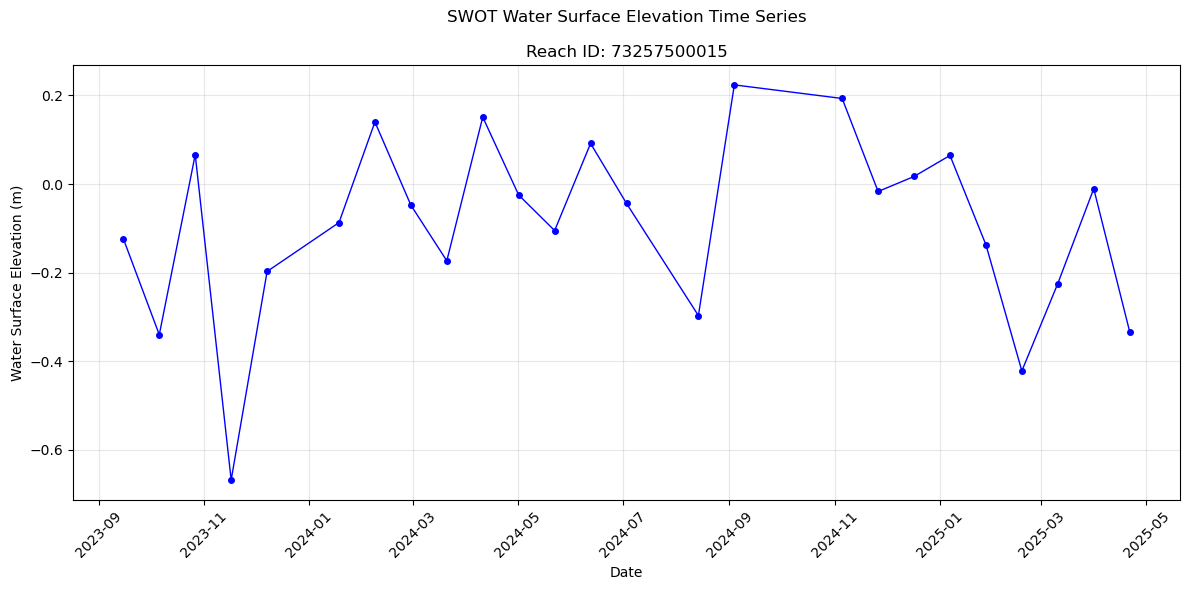

Data saved to: swot_reach_73257500015_2023-07-28_2025-05-03.csv

Processing Reach ID: 74100300015
Querying reach_id: 74100300015
Parameters: {'feature': 'Reach', 'feature_id': '74100300015', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2025-05-03T00:00:00Z', 'fields': 'reach_id,time_str,wse,width,area_total'}
Response status code: 200
Successfully retrieved 36 records
Original data: 36 records
Removed 3 fill value records
Final data after quality filtering: 33 records

=== Results for Reach 74100300015 ===
Number of observations: 33
Date range: 2023-08-29 17:19:30+00:00 to 2025-04-25 19:06:48+00:00
Water Surface Elevation:
  Mean: 0.10 m
  Min: -0.41 m
  Max: 0.74 m
  Std: 0.27 m
River Width:
  Mean: 350.87 m
  Min: 25.46 m
  Max: 942.19 m
Total Area:
  Mean: 977060 m²
  Min: 19335 m²
  Max: 2925460 m²


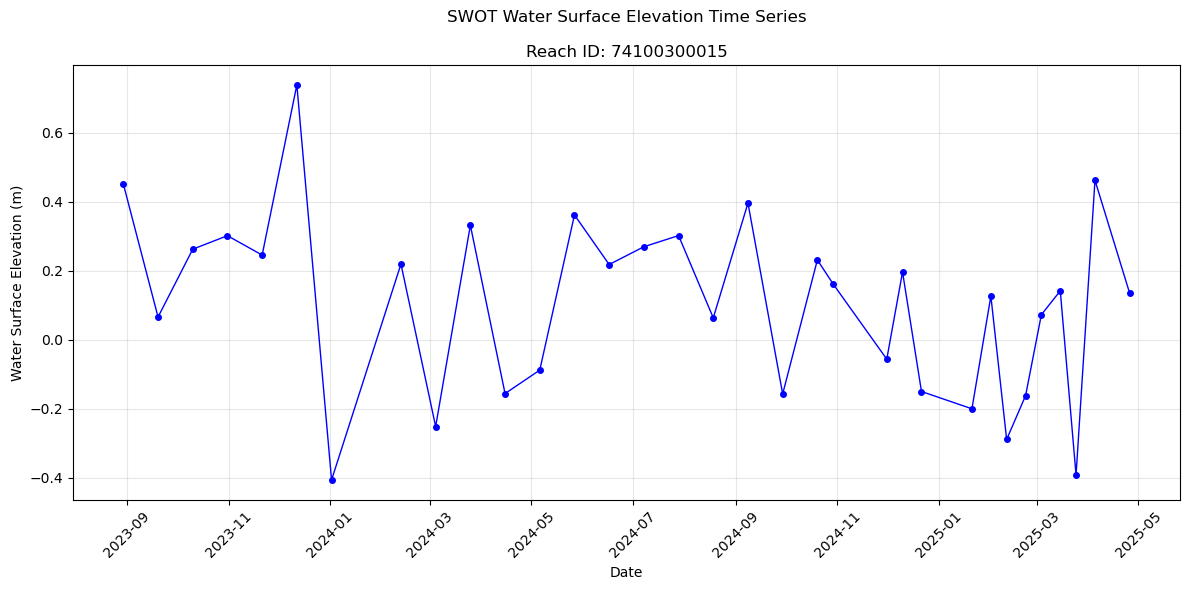

Data saved to: swot_reach_74100300015_2023-07-28_2025-05-03.csv

Processing Reach ID: 74100900025
Querying reach_id: 74100900025
Parameters: {'feature': 'Reach', 'feature_id': '74100900025', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2025-05-03T00:00:00Z', 'fields': 'reach_id,time_str,wse,width,area_total'}
Response status code: 200
Successfully retrieved 84 records
Original data: 84 records
Removed 18 fill value records
Final data after quality filtering: 66 records

=== Results for Reach 74100900025 ===
Number of observations: 66
Date range: 2023-07-28 11:20:11+00:00 to 2025-04-25 19:06:59+00:00
Water Surface Elevation:
  Mean: 0.08 m
  Min: -2.29 m
  Max: 2.44 m
  Std: 0.61 m
River Width:
  Mean: 649.97 m
  Min: 465.45 m
  Max: 876.21 m
Total Area:
  Mean: 6456954 m²
  Min: 2739628 m²
  Max: 9670430 m²


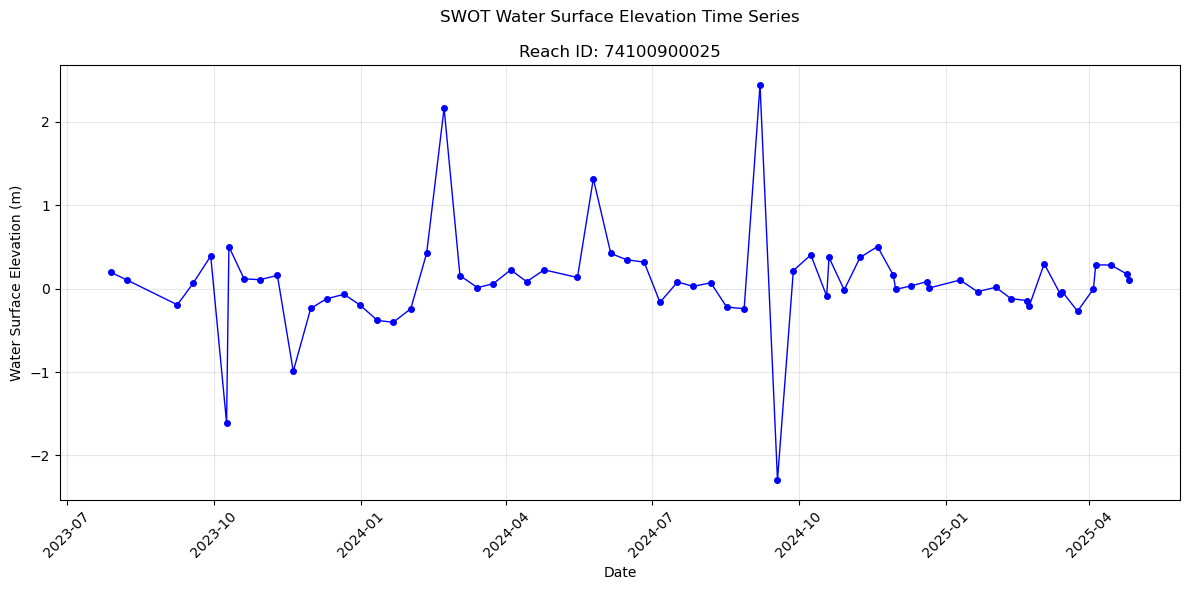

Data saved to: swot_reach_74100900025_2023-07-28_2025-05-03.csv

Processing Reach ID: 74100900015
Querying reach_id: 74100900015
Parameters: {'feature': 'Reach', 'feature_id': '74100900015', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2025-05-03T00:00:00Z', 'fields': 'reach_id,time_str,wse,width,area_total'}
Response status code: 200
Successfully retrieved 84 records
Original data: 84 records
Removed 1 fill value records
Final data after quality filtering: 83 records

=== Results for Reach 74100900015 ===
Number of observations: 83
Date range: 2023-07-28 11:20:11+00:00 to 2025-04-25 19:07:08+00:00
Water Surface Elevation:
  Mean: 0.01 m
  Min: -2.18 m
  Max: 1.36 m
  Std: 0.45 m
River Width:
  Mean: 359.62 m
  Min: 265.99 m
  Max: 411.01 m
Total Area:
  Mean: 4760244 m²
  Min: 1300869 m²
  Max: 7244120 m²


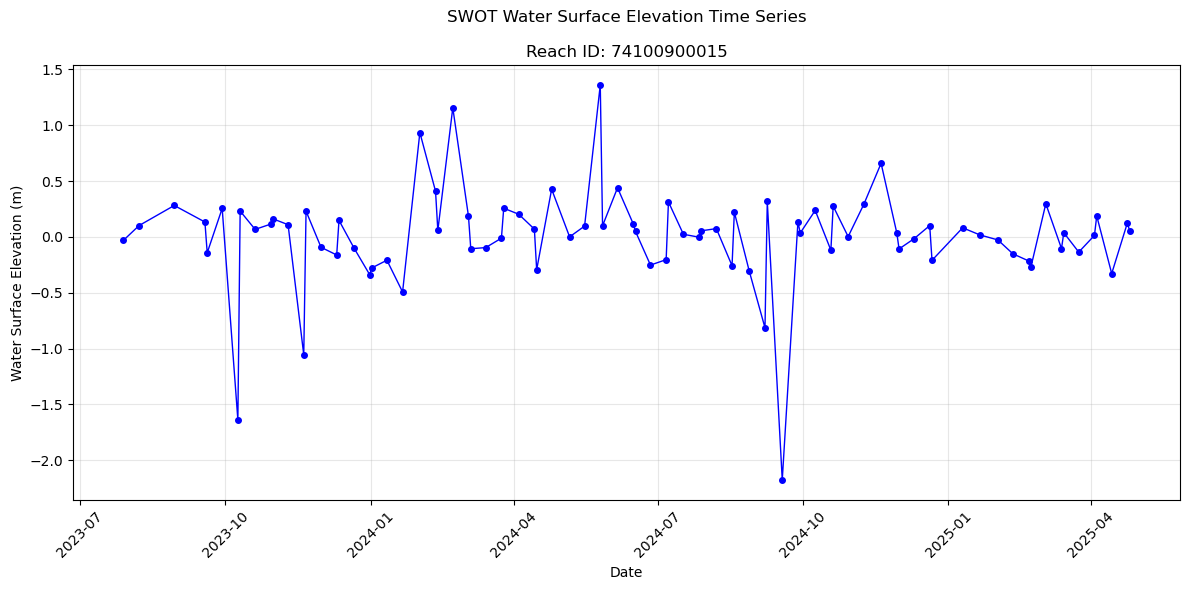

Data saved to: swot_reach_74100900015_2023-07-28_2025-05-03.csv

Processing Reach ID: 74300100025
Querying reach_id: 74300100025
Parameters: {'feature': 'Reach', 'feature_id': '74300100025', 'output': 'csv', 'start_time': '2023-07-28T00:00:00Z', 'end_time': '2025-05-03T00:00:00Z', 'fields': 'reach_id,time_str,wse,width,area_total'}
Response status code: 200
Successfully retrieved 83 records
Original data: 83 records
Removed 2 fill value records
Final data after quality filtering: 81 records

=== Results for Reach 74300100025 ===
Number of observations: 81
Date range: 2023-07-28 11:20:04+00:00 to 2025-04-25 19:07:08+00:00
Water Surface Elevation:
  Mean: 0.01 m
  Min: -1.97 m
  Max: 1.64 m
  Std: 0.45 m
River Width:
  Mean: 577.20 m
  Min: 454.90 m
  Max: 621.84 m
Total Area:
  Mean: 6305246 m²
  Min: 3512356 m²
  Max: 6888865 m²


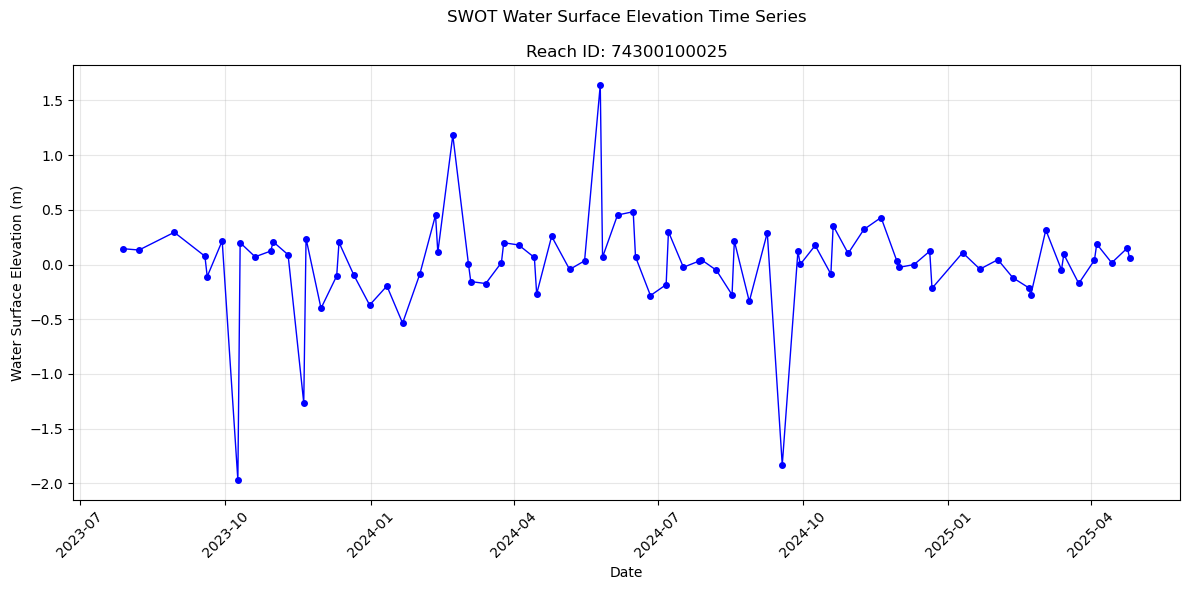

Data saved to: swot_reach_74300100025_2023-07-28_2025-05-03.csv

COMBINED SUMMARY

Reach Summary:
   reach_id river_name  num_observations  success
73257500015                           25     True
74100300015                           33     True
74100900025                           66     True
74100900015                           83     True
74300100025                           81     True

Reaches with data (5 of 5):
  73257500015: 25 observations
    WSE: -0.09 ± 0.21 m
    Width: 1025 m
  74100300015: 33 observations
    WSE: 0.10 ± 0.27 m
    Width: 351 m
  74100900025: 66 observations
    WSE: 0.08 ± 0.61 m
    Width: 650 m
  74100900015: 83 observations
    WSE: 0.01 ± 0.45 m
    Width: 360 m
  74300100025: 81 observations
    WSE: 0.01 ± 0.45 m
    Width: 577 m

Combined summary saved to: swot_multi_reach_summary_2023-07-28_2025-05-03.csv

Analysis Complete!


In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from io import StringIO

# API URLs
FTS_URL = "https://fts.podaac.earthdata.nasa.gov/v1"  
HYDROCRON_URL = "https://soto.podaac.earthdatacloud.nasa.gov/hydrocron/v1/timeseries"

def query_hydrocron_single_reach(reach_id, start_time, end_time, fields="reach_id,time_str,wse"):
    """Query Hydrocron for reach-level time series data for a single reach."""
    
    # Create an empty dataframe for cases where no data is returned
    empty_df = pd.DataFrame({
        "reach_id": [reach_id],
        "time_str": [datetime.datetime(1900, 1, 1).strftime("%Y-%m-%dT%H:%M:%S")],
        "wse": [-999999999999.0],
        "wse_units": ["m"]
    })

    params = {
        "feature": "Reach",
        "feature_id": reach_id,
        "output": "csv",
        "start_time": start_time,
        "end_time": end_time,
        "fields": fields
    }
    
    print(f"Querying reach_id: {reach_id}")
    print(f"Parameters: {params}")
    
    try:
        results = requests.get(HYDROCRON_URL, params=params)
        print(f"Response status code: {results.status_code}")
        
        if results.status_code == 200:
            response_json = results.json()
            
            if "results" in response_json.keys():
                results_csv = response_json["results"]["csv"]
                if results_csv.strip():  # Check if not empty
                    df = pd.read_csv(StringIO(results_csv))
                    print(f"Successfully retrieved {len(df)} records")
                else:
                    print("Empty CSV response")
                    df = empty_df
            else:
                print("No 'results' key in response")
                df = empty_df
        else:
            print(f"HTTP error {results.status_code}")
            try:
                error_response = results.json()
                print(f"Error details: {error_response}")
            except:
                print(f"Error text: {results.text}")
            df = empty_df
            
    except Exception as e:
        print(f"Error querying Hydrocron: {e}")
        df = empty_df

    return df

def clean_and_process_data(df):
    """Clean and process the data - fixed pandas warning"""
    if df.empty:
        return df
        
    print(f"Original data: {len(df)} records")
    
    # Remove fill values for missing observations
    original_length = len(df)
    df = df.loc[(df["wse"] != -999999999999.0)].copy()  # Added .copy() to fix warning
    removed_count = original_length - len(df)
    if removed_count > 0:
        print(f"Removed {removed_count} fill value records")
    
    # Quality filtering based on available fields
    if 'wse_qual' in df.columns:
        original_length = len(df)
        df = df.loc[df['wse_qual'] == 0].copy()
        removed_count = original_length - len(df)
        print(f"Quality filtering: removed {removed_count} poor quality records (wse_qual != 0)")
    
    if 'obs_frac_n' in df.columns:
        original_length = len(df)
        df = df.loc[df['obs_frac_n'] > 0.8].copy()
        removed_count = original_length - len(df)
        print(f"Node coverage filtering: removed {removed_count} records with obs_frac_n <= 0.8")
    
    if 'n_good_nod' in df.columns:
        original_length = len(df)
        df = df.loc[df['n_good_nod'] >= 5].copy()
        removed_count = original_length - len(df)
        print(f"Good nodes filtering: removed {removed_count} records with n_good_nod < 5")
    
    # Convert time_str to datetime format - fixed warning
    if 'time_str' in df.columns and len(df) > 0:
        df = df.copy()  # Ensure we have a copy
        df['time_str'] = pd.to_datetime(df['time_str'])
    
    print(f"Final data after quality filtering: {len(df)} records")
    return df

def plot_timeseries(df, reach_id, river_name=""):
    """Plot the time series data for water surface elevation."""
    if df.empty:
        print("No data to plot")
        return
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['time_str'], df['wse'], 'b-o', markersize=4, linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Water Surface Elevation (m)')
    title = f'SWOT Water Surface Elevation Time Series\n{river_name}\nReach ID: {reach_id}'
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def get_river_name_from_reach_id(reach_id):
    """Try to get river name from FTS (optional - may not always work)"""
    try:
        # Try to query FTS for river name
        query_url = f"{FTS_URL}/rivers/reach/{reach_id}"
        response = requests.get(query_url, params={"page_size": 1, "page_number": 1})
        if response.status_code == 200:
            data = response.json()
            if 'results' in data and len(data['results']) > 0:
                # FTS doesn't always return river names, so this is optional
                return ""
        return ""
    except:
        return ""

def process_single_reach(reach_id, start_time, end_time, fields=None):
    """Process a single reach and return summary info"""
    
    if fields is None:
        fields = "reach_id,time_str,wse,width,area_total"
    
    print(f"\n{'='*60}")
    print(f"Processing Reach ID: {reach_id}")
    print(f"{'='*60}")
    
    # Get river name (if possible)
    river_name = get_river_name_from_reach_id(reach_id)
    
    # Query Hydrocron
    df = query_hydrocron_single_reach(reach_id, start_time, end_time, fields)
    
    # Process data
    df = clean_and_process_data(df)
    
    summary = {
        "reach_id": reach_id,
        "river_name": river_name,
        "num_observations": len(df),
        "success": not df.empty
    }
    
    if not df.empty:
        print(f"\n=== Results for Reach {reach_id} ===")
        print(f"Number of observations: {len(df)}")
        print(f"Date range: {df['time_str'].min()} to {df['time_str'].max()}")
        
        # Basic statistics
        if 'wse' in df.columns:
            print(f"Water Surface Elevation:")
            print(f"  Mean: {df['wse'].mean():.2f} m")
            print(f"  Min: {df['wse'].min():.2f} m")
            print(f"  Max: {df['wse'].max():.2f} m")
            print(f"  Std: {df['wse'].std():.2f} m")
            
            summary.update({
                "date_range_start": df['time_str'].min(),
                "date_range_end": df['time_str'].max(),
                "mean_wse_m": df['wse'].mean(),
                "min_wse_m": df['wse'].min(),
                "max_wse_m": df['wse'].max(),
                "std_wse_m": df['wse'].std()
            })
        
        if 'width' in df.columns:
            print(f"River Width:")
            print(f"  Mean: {df['width'].mean():.2f} m")
            print(f"  Min: {df['width'].min():.2f} m")
            print(f"  Max: {df['width'].max():.2f} m")
            
            summary.update({
                "mean_width_m": df['width'].mean(),
                "min_width_m": df['width'].min(),
                "max_width_m": df['width'].max()
            })
        
        if 'area_total' in df.columns:
            print(f"Total Area:")
            print(f"  Mean: {df['area_total'].mean():.0f} m²")
            print(f"  Min: {df['area_total'].min():.0f} m²")
            print(f"  Max: {df['area_total'].max():.0f} m²")
            
            summary.update({
                "mean_area_m2": df['area_total'].mean(),
                "min_area_m2": df['area_total'].min(),
                "max_area_m2": df['area_total'].max()
            })
        
        # Plot the time series
        plot_timeseries(df, reach_id, river_name)
        
        # Save individual files
        output_filename = f"swot_reach_{reach_id}_{start_time[:10]}_{end_time[:10]}.csv"
        df.to_csv(output_filename, index=False)
        print(f"Data saved to: {output_filename}")
        
    else:
        print(f"\n=== No Data Available for Reach {reach_id} ===")
        print("This reach may not have SWOT observations in the specified time range.")
        
        summary.update({
            "date_range_start": None,
            "date_range_end": None,
            "mean_wse_m": None,
            "min_wse_m": None,
            "max_wse_m": None,
            "std_wse_m": None,
            "mean_width_m": None,
            "min_width_m": None,
            "max_width_m": None,
            "mean_area_m2": None,
            "min_area_m2": None,
            "max_area_m2": None
        })
    
    return summary

# Multiple reach analysis
if __name__ == "__main__":
    # List of reach IDs to process
    reach_ids = [
        "73257500015",  # Caloosahatchee River
        "74100300015",  # Mulatto Bayou 
        "74100900025",  # Pass a Loutre
        "74100900015",   # South pass; Southwest pass
        "74300100025" # Mississippi River
    ]
    
    # Time parameters
    start_time = "2023-07-28T00:00:00Z"
    end_time = "2025-05-03T00:00:00Z"
    
    # Fields to download
    fields = "reach_id,time_str,wse,width,area_total"
    
    print("SWOT Multi-Reach Analysis")
    print("=" * 60)
    print(f"Analyzing {len(reach_ids)} reach IDs")
    print(f"Time range: {start_time} to {end_time}")
    
    # Process all reaches
    all_summaries = []
    
    for reach_id in reach_ids:
        summary = process_single_reach(reach_id, start_time, end_time, fields)
        all_summaries.append(summary)
    
    # Create combined summary
    print(f"\n{'='*60}")
    print("COMBINED SUMMARY")
    print(f"{'='*60}")
    
    summary_df = pd.DataFrame(all_summaries)
    
    # Display summary table
    print("\nReach Summary:")
    print(summary_df[['reach_id', 'river_name', 'num_observations', 'success']].to_string(index=False))
    
    # Show successful reaches with data
    successful_reaches = summary_df[summary_df['success'] == True]
    if len(successful_reaches) > 0:
        print(f"\nReaches with data ({len(successful_reaches)} of {len(reach_ids)}):")
        for _, row in successful_reaches.iterrows():
            print(f"  {row['reach_id']}: {row['num_observations']} observations")
            if pd.notna(row['mean_wse_m']):
                print(f"    WSE: {row['mean_wse_m']:.2f} ± {row['std_wse_m']:.2f} m")
            if pd.notna(row['mean_width_m']):
                print(f"    Width: {row['mean_width_m']:.0f} m")
    
    # Save combined summary
    summary_filename = f"swot_multi_reach_summary_{start_time[:10]}_{end_time[:10]}.csv"
    summary_df.to_csv(summary_filename, index=False)
    print(f"\nCombined summary saved to: {summary_filename}")
    
    print(f"\n{'='*60}")
    print("Analysis Complete!")
    print(f"{'='*60}")

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import glob
import os

def calculate_monthly_averages(csv_file_path):
    """
    Calculate monthly averages from SWOT time series data
    
    Parameters:
    -----------
    csv_file_path : str
        Path to the CSV file containing SWOT data
        
    Returns:
    --------
    pandas.DataFrame
        Monthly averaged data with StdTime set to first of each month
    """
    
    # Read the CSV file
    try:
        df = pd.read_csv(csv_file_path)
        print(f"Processing {csv_file_path}")
        print(f"  Original data: {len(df)} records")
        
        if df.empty:
            print(f"  No data in file")
            return pd.DataFrame()
        
        # Ensure time_str is datetime
        df['time_str'] = pd.to_datetime(df['time_str'])
        
        # Extract reach_id for the output
        reach_id = df['reach_id'].iloc[0]
        
        # Create year-month grouping
        df['year_month'] = df['time_str'].dt.to_period('M')
        
        # Calculate monthly statistics
        monthly_stats = []
        
        for period, group in df.groupby('year_month'):
            # Create StdTime as first day of the month
            std_time = period.start_time
            
            # Calculate statistics for each numeric column
            month_data = {
                'reach_id': reach_id,
                'StdTime': std_time,
                'year_month': str(period),
                'num_observations': len(group)
            }
            
            # Calculate averages for numeric columns
            numeric_columns = ['wse', 'width', 'area_total']
            for col in numeric_columns:
                if col in group.columns:
                    # Calculate mean, std, min, max, count
                    month_data[f'{col}_mean'] = group[col].mean()
                    month_data[f'{col}_std'] = group[col].std()
                    month_data[f'{col}_min'] = group[col].min()
                    month_data[f'{col}_max'] = group[col].max()
                    month_data[f'{col}_count'] = group[col].count()
            
            # Add first and last observation dates for the month
            month_data['first_obs_date'] = group['time_str'].min()
            month_data['last_obs_date'] = group['time_str'].max()
            
            monthly_stats.append(month_data)
        
        # Convert to DataFrame
        monthly_df = pd.DataFrame(monthly_stats)
        
        # Sort by StdTime
        monthly_df = monthly_df.sort_values('StdTime').reset_index(drop=True)
        
        print(f"  Monthly data: {len(monthly_df)} months")
        print(f"  Date range: {monthly_df['StdTime'].min().strftime('%Y-%m')} to {monthly_df['StdTime'].max().strftime('%Y-%m')}")
        
        return monthly_df
        
    except Exception as e:
        print(f"Error processing {csv_file_path}: {e}")
        return pd.DataFrame()

def process_all_reach_files():
    """
    Process all SWOT reach CSV files and create monthly averages
    """
    
    # Find all SWOT reach CSV files in current directory
    csv_files = glob.glob("swot_reach_*.csv")
    
    if not csv_files:
        print("No SWOT reach CSV files found!")
        print("Looking for files matching pattern: swot_reach_*.csv")
        return
    
    print(f"Found {len(csv_files)} SWOT reach files:")
    for file in csv_files:
        print(f"  {file}")
    print()
    
    # Process each file
    for csv_file in csv_files:
        print(f"{'='*60}")
        
        # Calculate monthly averages
        monthly_df = calculate_monthly_averages(csv_file)
        
        if not monthly_df.empty:
            # Extract reach_id from filename or data
            reach_id = monthly_df['reach_id'].iloc[0]
            
            # Create output filename
            base_name = os.path.splitext(csv_file)[0]
            output_file = f"{base_name}_monthly_averages.csv"
            
            # Save monthly averages
            monthly_df.to_csv(output_file, index=False)
            print(f"  Monthly averages saved to: {output_file}")
            
            # Display summary
            print(f"  Summary for Reach {reach_id}:")
            if 'wse_mean' in monthly_df.columns:
                print(f"    WSE range: {monthly_df['wse_mean'].min():.2f} to {monthly_df['wse_mean'].max():.2f} m")
                print(f"    WSE overall mean: {monthly_df['wse_mean'].mean():.2f} m")
            
            if 'width_mean' in monthly_df.columns:
                print(f"    Width range: {monthly_df['width_mean'].min():.0f} to {monthly_df['width_mean'].max():.0f} m")
                print(f"    Width overall mean: {monthly_df['width_mean'].mean():.0f} m")
            
            print(f"    Months with data: {len(monthly_df)}")
            print(f"    Total observations used: {monthly_df['num_observations'].sum()}")
            
        else:
            print(f"  No data to process")
        
        print()

def create_combined_monthly_summary():
    """
    Create a combined summary of all monthly averages
    """
    
    # Find all monthly average files
    monthly_files = glob.glob("*_monthly_averages.csv")
    
    if not monthly_files:
        print("No monthly average files found!")
        return
    
    print(f"Creating combined summary from {len(monthly_files)} monthly files...")
    
    all_monthly_data = []
    
    for file in monthly_files:
        try:
            df = pd.read_csv(file)
            df['source_file'] = file
            all_monthly_data.append(df)
        except Exception as e:
            print(f"Error reading {file}: {e}")
    
    if all_monthly_data:
        # Combine all data
        combined_df = pd.concat(all_monthly_data, ignore_index=True)
        
        # Sort by reach_id and StdTime
        combined_df = combined_df.sort_values(['reach_id', 'StdTime']).reset_index(drop=True)
        
        # Save combined file
        combined_file = "swot_all_reaches_monthly_summary.csv"
        combined_df.to_csv(combined_file, index=False)
        
        print(f"Combined monthly summary saved to: {combined_file}")
        print(f"Total monthly records: {len(combined_df)}")
        print(f"Reaches included: {combined_df['reach_id'].nunique()}")
        print(f"Date range: {combined_df['StdTime'].min()} to {combined_df['StdTime'].max()}")
        
        # Show reach summary
        reach_summary = combined_df.groupby('reach_id').agg({
            'StdTime': ['count', 'min', 'max'],
            'num_observations': 'sum'
        }).round(2)
        
        reach_summary.columns = ['months_of_data', 'first_month', 'last_month', 'total_observations']
        
        print(f"\nReach Summary:")
        print(reach_summary.to_string())

# Main execution
if __name__ == "__main__":
    print("SWOT Monthly Averages Calculator")
    print("=" * 60)
    print("This script will:")
    print("1. Find all SWOT reach CSV files (swot_reach_*.csv)")
    print("2. Calculate monthly averages for each reach")
    print("3. Set StdTime to the first day of each month")
    print("4. Create individual monthly CSV files")
    print("5. Create a combined summary file")
    print()
    
    # Process all reach files
    process_all_reach_files()
    
    print("=" * 60)
    print("Creating Combined Summary")
    print("=" * 60)
    
    # Create combined summary
    create_combined_monthly_summary()
    
    print("=" * 60)
    print("Monthly Processing Complete!")
    print("=" * 60)
    print("\nFiles created:")
    print("- Individual monthly files: *_monthly_averages.csv")
    print("- Combined summary: swot_all_reaches_monthly_summary.csv")

SWOT Monthly Averages Calculator
This script will:
1. Find all SWOT reach CSV files (swot_reach_*.csv)
2. Calculate monthly averages for each reach
3. Set StdTime to the first day of each month
4. Create individual monthly CSV files
5. Create a combined summary file

Found 13 SWOT reach files:
  swot_reach_61100201775_2023-07-28_2025-05-03.csv
  swot_reach_61100201775_2023-07-28_2025-05-03_monthly_averages.csv
  swot_reach_61201000225_2023-07-28_2025-05-03.csv
  swot_reach_61201000225_2023-07-28_2025-05-03_monthly_averages.csv
  swot_reach_73257500015_2023-07-28_2025-05-03.csv
  swot_reach_74100300015_2023-07-28_2025-05-03.csv
  swot_reach_74100900015_2023-07-28_2025-05-03.csv
  swot_reach_74100900025_2023-07-28_2025-05-03.csv
  swot_reach_74300100025_2023-07-28_2025-05-03.csv
  swot_reach_75376000081_2023-07-28_2025-05-03.csv
  swot_reach_75376000081_2023-07-28_2025-05-03_monthly_averages.csv
  swot_reach_75380100011_2023-07-28_2025-05-03.csv
  swot_reach_75380100011_2023-07-28_2025-0

C:\Users\jspier\AppData\Local\Temp\ipykernel_18776\3085897857.py:39: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time_str'].dt.to_period('M')
C:\Users\jspier\AppData\Local\Temp\ipykernel_18776\3085897857.py:39: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time_str'].dt.to_period('M')
C:\Users\jspier\AppData\Local\Temp\ipykernel_18776\3085897857.py:39: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time_str'].dt.to_period('M')
C:\Users\jspier\AppData\Local\Temp\ipykernel_18776\3085897857.py:39: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['time_str'].dt.to_period('M')
C:\Users\jspier\AppData\Local\Temp\ipykernel_18776\3085897857.py:39: UserWarning: Converting to PeriodArray/Index representation will drop t

In [8]:
import xarray as xr
import earthaccess
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set your target reach ID
target_reach_id = 74300100025

# Login using .netrc credentials
print("Logging in with .netrc credentials...")
auth = earthaccess.login()

# Search for SWOT SoS discharge data
print("Searching for SWOT SoS discharge data...")
granule_info = earthaccess.search_data(
    short_name="SWOT_L4_DAWG_SOS_DISCHARGE",
    temporal=("2023-01-01", "2024-12-31"),  # Extended time range
)

print(f"Found {len(granule_info)} granules")

# Filter for SWORD v17 version C files
print("Filtering for SWORD v17 version C files...")
v17_granules = []
for granule in granule_info:
    granule_urls = earthaccess.results.DataGranule.data_links(granule)
    for url in granule_urls:
        # Look for v17 and version C indicators in filename
        if 'sword_v17' in url.lower() and ('version_c' in url.lower() or '_c_' in url.lower()):
            v17_granules.append(granule)
            print(f"Found v17 version C file: {url}")
            break

if not v17_granules:
    print("No SWORD v17 version C files found. Available files:")
    for granule in granule_info[:5]:  # Show first 5 as examples
        granule_urls = earthaccess.results.DataGranule.data_links(granule)
        for url in granule_urls:
            if 'results.nc' in url:
                print(f"  {url}")
    
    print("\nUsing available files (may not be v17 version C)...")
    granule_info_to_use = granule_info
else:
    print(f"Using {len(v17_granules)} SWORD v17 version C granules")
    granule_info_to_use = v17_granules

# Function to search for reach across all files
def find_reach_in_sos_files(reach_id, granule_info):
    """Search through SoS files to find the reach and extract discharge data"""
    
    # Download the files locally for easier access
    files = earthaccess.download(granule_info, local_path="./")
    
    for file_path in files:
        if "results" not in file_path:
            continue
            
        try:
            print(f"Checking file: {file_path}")
            
            # Check if this is SWORD v17 version C
            if 'sword_v17' in file_path.lower():
                if 'version_c' in file_path.lower() or '_c_' in file_path.lower():
                    print("  ✓ This is SWORD v17 version C data")
                else:
                    print("  ! This is SWORD v17 but may not be version C")
            else:
                print(f"  ! This may not be SWORD v17 data: {file_path}")
            
            # Open the results file
            results = nc.Dataset(file_path, format="NETCDF4")
            
            # Check dataset attributes for version info
            if hasattr(results, 'sword_version'):
                print(f"  SWORD version: {results.sword_version}")
            if hasattr(results, 'river_database_version'):
                print(f"  River database version: {results.river_database_version}")
            
            # Get reach IDs from the reaches group
            reach_ids = results.groups['reaches'].variables['reach_id'][:]
            
            # Check if our reach exists in this file
            if reach_id in reach_ids:
                print(f"✓ Found reach {reach_id} in {file_path}")
                
                # Get the index of our reach
                reach_index = np.where(reach_ids == reach_id)[0][0]
                
                # Get reach information
                river_name = results.groups['reaches'].variables['river_name'][reach_index]
                reach_lon = results.groups['reaches'].variables['x'][reach_index]
                reach_lat = results.groups['reaches'].variables['y'][reach_index]
                
                print(f"River name: {river_name}")
                print(f"Location: {reach_lat:.3f}°N, {reach_lon:.3f}°E")
                
                # Extract discharge data from different algorithms
                algorithms = ['hivdi', 'metroman', 'momma', 'neobam', 'sad', 'sic4dvar']
                discharge_data = {}
                
                # Get time data once
                time_data = results.groups['reaches'].variables['time'][reach_index]
                time_missing = results.groups['reaches'].variables['time'].missing_value
                
                print(f"Time data shape: {time_data.shape if hasattr(time_data, 'shape') else 'scalar'}")
                print(f"Time data sample: {time_data[:5] if hasattr(time_data, '__len__') and len(time_data) > 1 else time_data}")
                
                for algo in algorithms:
                    try:
                        print(f"  Trying algorithm: {algo}")
                        
                        if algo == 'hivdi':
                            q_var = 'Q'
                        elif algo == 'metroman':
                            q_var = 'allq'
                        elif algo == 'momma':
                            q_var = 'Q'
                        elif algo == 'neobam':
                            q_var = 'q1'  # or q2, q3
                        elif algo == 'sad':
                            q_var = 'Qa'
                        elif algo == 'sic4dvar':
                            q_var = 'Q_da'
                        
                        # Check if algorithm group exists
                        if algo in results.groups:
                            print(f"    Found {algo} group")
                            algo_group = results.groups[algo]
                            
                            discharge = None
                            missing_val = None
                            
                            # Check if discharge variable exists for neoBAM
                            if algo == 'neobam' and 'q' in algo_group.groups:
                                if q_var in algo_group.groups['q'].variables:
                                    discharge = algo_group.groups['q'].variables[q_var][reach_index]
                                    missing_val = algo_group.groups['q'].variables[q_var].missing_value
                                    print(f"    Found neoBAM {q_var}")
                            elif q_var in algo_group.variables:
                                discharge = algo_group.variables[q_var][reach_index]
                                missing_val = algo_group.variables[q_var].missing_value
                                print(f"    Found {q_var} variable")
                            else:
                                print(f"    {q_var} not found in {algo} group")
                                continue
                            
                            if discharge is not None:
                                print(f"    Discharge shape: {discharge.shape if hasattr(discharge, 'shape') else 'scalar'}")
                                print(f"    Discharge sample: {discharge[:5] if hasattr(discharge, '__len__') and len(discharge) > 1 else discharge}")
                                print(f"    Missing value: {missing_val}")
                                
                                # Filter out missing values
                                if hasattr(discharge, '__len__') and len(discharge) > 1:
                                    # Multiple time steps
                                    if hasattr(time_data, '__len__') and len(time_data) > 1:
                                        valid_idx = (discharge != missing_val) & (time_data != time_missing)
                                    else:
                                        valid_idx = (discharge != missing_val)
                                    
                                    if np.any(valid_idx):
                                        discharge_data[algo] = {
                                            'discharge': discharge[valid_idx],
                                            'time': time_data[valid_idx] if hasattr(time_data, '__len__') and len(time_data) > 1 else np.array([time_data]),
                                            'variable': q_var
                                        }
                                        print(f"    ✓ Extracted {np.sum(valid_idx)} valid discharge values")
                                    else:
                                        print(f"    No valid discharge values (all missing)")
                                elif discharge != missing_val and (not hasattr(time_data, '__len__') or time_data != time_missing):
                                    # Single time step
                                    discharge_data[algo] = {
                                        'discharge': np.array([discharge]),
                                        'time': np.array([time_data]),
                                        'variable': q_var
                                    }
                                    print(f"    ✓ Extracted single discharge value: {discharge}")
                                else:
                                    print(f"    Single discharge value is missing")
                        else:
                            print(f"    {algo} group not found")
                                
                    except Exception as e:
                        print(f"Could not extract {algo} data: {e}")
                        continue
                
                # Also try to get MOI (integrated) results
                print("  Checking MOI results...")
                if 'moi' in results.groups:
                    print("    Found MOI group")
                    for algo in algorithms:
                        try:
                            if algo in results.groups['moi'].groups:
                                print(f"    Checking MOI {algo}")
                                moi_discharge = results.groups['moi'].groups[algo].variables['q'][reach_index]
                                moi_missing = results.groups['moi'].groups[algo].variables['q'].missing_value
                                
                                print(f"    MOI {algo} discharge: {moi_discharge[:5] if hasattr(moi_discharge, '__len__') and len(moi_discharge) > 1 else moi_discharge}")
                                
                                if hasattr(moi_discharge, '__len__') and len(moi_discharge) > 1:
                                    if hasattr(time_data, '__len__') and len(time_data) > 1:
                                        valid_idx = (moi_discharge != moi_missing) & (time_data != time_missing)
                                    else:
                                        valid_idx = (moi_discharge != moi_missing)
                                    
                                    if np.any(valid_idx):
                                        discharge_data[f'moi_{algo}'] = {
                                            'discharge': moi_discharge[valid_idx],
                                            'time': time_data[valid_idx] if hasattr(time_data, '__len__') and len(time_data) > 1 else np.array([time_data]),
                                            'variable': 'q'
                                        }
                                        print(f"    ✓ Extracted MOI {algo} data")
                                elif moi_discharge != moi_missing:
                                    discharge_data[f'moi_{algo}'] = {
                                        'discharge': np.array([moi_discharge]),
                                        'time': np.array([time_data]),
                                        'variable': 'q'
                                    }
                                    print(f"    ✓ Extracted single MOI {algo} value")
                        except Exception as e:
                            print(f"    Error with MOI {algo}: {e}")
                            continue
                else:
                    print("    No MOI group found")
                
                results.close()
                return discharge_data, river_name, reach_lon, reach_lat
                
            results.close()
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    return None, None, None, None

# Search for the reach
print(f"\nSearching for reach ID {target_reach_id}...")
discharge_data, river_name, reach_lon, reach_lat = find_reach_in_sos_files(target_reach_id, granule_info_to_use)

if discharge_data:
    print(f"\n✓ Successfully found discharge data!")
    print(f"River: {river_name}")
    print(f"Reach ID: {target_reach_id}")
    print(f"Location: {reach_lat:.3f}°N, {reach_lon:.3f}°E")
    print(f"Available algorithms: {list(discharge_data.keys())}")
    
    # Convert times to datetime
    def convert_swot_time(time_seconds):
        """Convert SWOT time (seconds since 2000-01-01) to datetime"""
        reference_date = datetime(2000, 1, 1, 0, 0, 0)
        return [reference_date + timedelta(seconds=t) for t in time_seconds]
    
    # Process all algorithms and create plots
    fig, axes = plt.subplots(len(discharge_data), 1, figsize=(12, 3*len(discharge_data)))
    if len(discharge_data) == 1:
        axes = [axes]
    
    for i, (algo, data) in enumerate(discharge_data.items()):
        # Convert time
        datetime_vals = convert_swot_time(data['time'])
        
        # Plot
        axes[i].plot(datetime_vals, data['discharge'], 'o-', linewidth=1.5, markersize=4)
        axes[i].set_title(f"{algo.upper()} Discharge Estimates")
        axes[i].set_ylabel(f"Discharge (m³/s)")
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(axis='x', rotation=45)
        
        # Print statistics
        print(f"\n{algo.upper()} Statistics:")
        print(f"  Variable: {data['variable']}")
        print(f"  Count: {len(data['discharge'])} estimates")
        print(f"  Mean: {np.mean(data['discharge']):.2f} m³/s")
        print(f"  Min: {np.min(data['discharge']):.2f} m³/s")
        print(f"  Max: {np.max(data['discharge']):.2f} m³/s")
        print(f"  Date range: {min(datetime_vals).strftime('%Y-%m-%d')} to {max(datetime_vals).strftime('%Y-%m-%d')}")
    
    plt.suptitle(f'Discharge Time Series for {river_name}\nReach ID: {target_reach_id}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Create a comparison plot if multiple algorithms are available
    if len(discharge_data) > 1:
        plt.figure(figsize=(12, 6))
        
        for algo, data in discharge_data.items():
            datetime_vals = convert_swot_time(data['time'])
            plt.plot(datetime_vals, data['discharge'], 'o-', 
                    label=f"{algo.upper()}", linewidth=1.5, markersize=4)
        
        plt.title(f'Discharge Algorithm Comparison\n{river_name} (Reach ID: {target_reach_id})')
        plt.xlabel('Date')
        plt.ylabel('Discharge (m³/s)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Save data to CSV
    print(f"\nSaving discharge data...")
    for algo, data in discharge_data.items():
        datetime_vals = convert_swot_time(data['time'])
        df = pd.DataFrame({
            'datetime': datetime_vals,
            'discharge_m3s': data['discharge'],
            'algorithm': algo,
            'variable': data['variable'],
            'reach_id': target_reach_id,
            'river_name': river_name
        })
        
        filename = f'discharge_{target_reach_id}_{algo}.csv'
        df.to_csv(filename, index=False)
        print(f"  Saved {filename}")

else:
    print(f"\n✗ Reach ID {target_reach_id} not found in any available files")
    print("This could mean:")
    print("  - The reach ID doesn't exist in the current dataset")
    print("  - The reach might be in a different time period")
    print("  - There might be a typo in the reach ID")
    
    # Show some example reach IDs
    try:
        print("\nChecking available reach IDs in first file...")
        files = earthaccess.download(granule_info[:1], local_path="./")
        if files:
            results = nc.Dataset(files[0], format="NETCDF4")
            if "results" in files[0]:
                sample_reaches = results.groups['reaches'].variables['reach_id'][:20]
                print("Example reach IDs:")
                for reach in sample_reaches:
                    print(f"  {reach}")
            results.close()
    except Exception as e:
        print(f"Could not display example reach IDs: {e}")

print("\nAnalysis complete!")

Logging in with .netrc credentials...
Searching for SWOT SoS discharge data...
Found 12 granules
Filtering for SWORD v17 version C files...
No SWORD v17 version C files found. Available files:
  https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/na_sword_v16_SOS_unconstrained_0001_20240611T010141_results.nc
  https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/na_sword_v16_SOS_unconstrained_0001_20240726T123358_results.nc
  https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/eu_sword_v16_SOS_unconstrained_0001_20240726T123345_results.nc
  https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/sa_sword_v16_SOS_unconstrained_0001_20240726T123343_results.nc
  https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_L4_DAWG_SOS_DISCHARGE/af_sword_v16_SOS_unconstrained_0001_20240726T123343_res

QUEUEING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/24 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/24 [00:00<?, ?it/s]

Checking file: na_sword_v16_SOS_unconstrained_0001_20240611T010141_results.nc
  ! This may not be SWORD v17 data: na_sword_v16_SOS_unconstrained_0001_20240611T010141_results.nc
✓ Found reach 74300100025 in na_sword_v16_SOS_unconstrained_0001_20240611T010141_results.nc
River name: Mississippi River
Location: 29.020°N, -89.339°E
Time data shape: (1,)
Time data sample: [-1.e+12]
  Trying algorithm: hivdi
    Found hivdi group
    Found Q variable
    Discharge shape: (1,)
    Discharge sample: [-1.e+12]
    Missing value: -999999999999.0
    Single discharge value is missing
  Trying algorithm: metroman
    Found metroman group
    Found allq variable
    Discharge shape: (1,)
    Discharge sample: [-1.e+12]
    Missing value: -999999999999.0
    Single discharge value is missing
  Trying algorithm: momma
    Found momma group
    Found Q variable
    Discharge shape: (1,)
    Discharge sample: [-1.e+12]
    Missing value: -999999999999.0
    Single discharge value is missing
  Trying alg

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

Example reach IDs:
  71120000013
  71120000043
  71120000053
  71120000063
  71130000071
  71120000083
  71120000091
  71120000101
  71120000111
  71120000121
  71120000131
  71120000143
  71120000153
  71120000161
  71120000173
  71120000183
  71120000193
  71120000203
  71120000303
  71120000313

Analysis complete!
